https://discourse.pymc.io/t/mixture-model-with-boxcox-transformation/988

In [1]:
%pylab inline
import pymc3 as pm
from scipy import special
import numpy.testing as npt
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


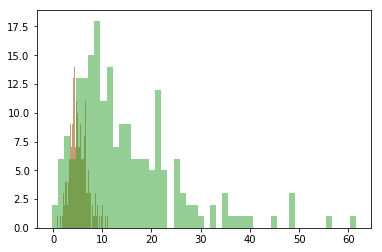

In [2]:
mu0, sd0 = 5., 2.
y = np.random.normal(mu0, sd0, size=200)
lam = 2.
y_tr = (np.power(y, lam) - 1.) / lam
plt.hist(y, bins=50, alpha=.5)
inv_boxcox = lambda x: np.power(x * lam + 1., 1. / lam)
plt.hist(inv_boxcox(y_tr), bins=50, alpha=.5);
plt.hist(y_tr, bins=50, alpha=.5);
# plt.hist(special.boxcox(y, lam), bins=50, alpha=.5);

In [3]:
from pymc3.distributions.transforms import ElemwiseTransform

class BoxCox(ElemwiseTransform):
    """Box-Cox transformation from real line to real line"""

    name = "boxcox"

    def __init__(self, lmbda):
        self.lmbda = tt.as_tensor_variable(lmbda)

    def backward(self, x):
        return tt.exp(tt.log1p(self.lmbda * x) / self.lmbda)

    def forward(self, y):
        return tt.expm1(self.lmbda * tt.log(y)) / self.lmbda

    def forward_val(self, y, point=None):
        lmbda = draw_values([self.lmbda], point=point)
        return np.expm1(lmbda * np.log(y)) / lmbda
    
boxcox = BoxCox(lam)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1235.21it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '32313' (I am process '32314')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '32313' (I am process '32315')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '32314' (I am process '32315')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2

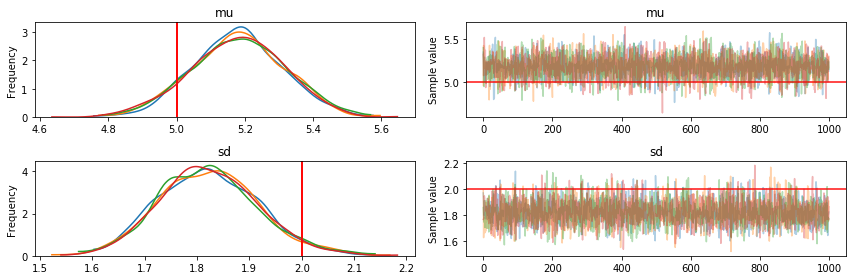

In [4]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfNormal('sd', 5.)
    obs = pm.Normal('y', mu, sd, observed=boxcox.backward(y_tr))
    trace = pm.sample(1000, tune=1000)

pm.traceplot(trace, lines=dict(mu=mu0, sd=sd0));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_boxcox__]
100%|██████████| 2000/2000 [00:01<00:00, 1593.69it/s]
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
There were 317 divergences after tuning. Increase `target_accept` or reparameterize.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


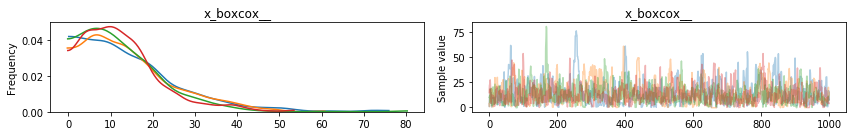

In [5]:
with pm.Model() as m:
    x = pm.Normal('x', mu0, sd0, transform=boxcox)
    trace = pm.sample(1000, tune=1000)

x_tr = m.free_RVs[0]
pm.traceplot(trace, varnames=[x_tr.name]);

In [6]:
x_tr = m.free_RVs[0]
jac = x_tr.distribution.transform_used.jacobian_det(theano.shared(np.array([-1, 2])))
print(x.ndim, x_tr.logp_elemwiset.ndim, jac.ndim)

0 0 1


In [7]:
def check_elementwise_logp_transform(model):
    x0 = model.deterministics[0]
    x = model.free_RVs[0]
    npt.assert_equal(x.ndim, x.logp_elemwiset.ndim)
    
    pt = model.test_point
    array = np.random.randn(*model.bijection.map(pt).shape)
    pt2 = model.bijection.rmap(array)
    dist = x.distribution
    logp_nojac = x0.distribution.logp(dist.transform_used.backward(pt2[x.name]))
    jacob_det = dist.transform_used.jacobian_det(theano.shared(pt2[x.name]))
    npt.assert_equal(x.logp_elemwiset.ndim, jacob_det.ndim)
    elementwiselogp = logp_nojac + jacob_det
                      
    npt.assert_array_almost_equal(x.logp_elemwise(pt2),
                                  elementwiselogp.eval())
    
check_elementwise_logp_transform(m)

In [8]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10.)
    sd = pm.HalfNormal('sd', 5.)
    y_latent = pm.Normal('y', mu, sd, transform=boxcox, testval=2.)

In [9]:
m.free_RVs

[mu, sd_log__, y_boxcox__]

In [10]:
y_boxcox = m.free_RVs[2]

with m:
    obs = pm.Potential('obs', y_boxcox.distribution.logp(theano.shared(y_tr)))

In [11]:
m.check_test_point()

mu           -3.22
sd_log__     -0.77
y_boxcox__   -3.12
Name: Log-probability of test_point, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_boxcox__, sd_log__, mu]
100%|██████████| 2000/2000 [00:02<00:00, 734.25it/s]
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.


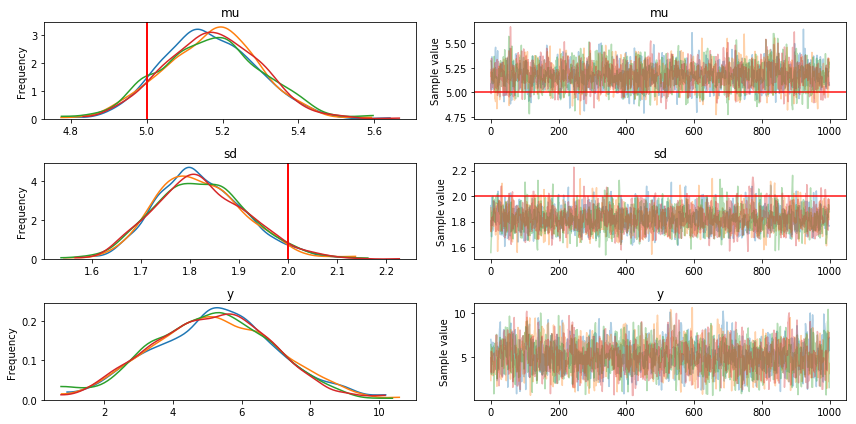

In [12]:
with m:
    trace = pm.sample(1000, tune=1000)

pm.traceplot(trace, lines=dict(mu=5., sd=2.));